<a href="https://colab.research.google.com/github/RoBorregos/home-pipelines/blob/vision-dataset/vision/dataset_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object detector dataset generator

With this notebook you'll be able to artificially generate and label
automatically a dataset for detecting objects. You can bring your own images or test it by fetching images from Kaggle hub.

If you want to mount your google drive, for training with checkpoints and saving your progress run the following cell.

In [5]:
!rm -rf /content/sample_data
!rm -rf /content/.config
from google.colab import drive
import os
drive.mount('/content', force_remount=True)
workdir = "/content/MyDrive/RoBorregos/vision/dataset_generator/"
os.makedirs(workdir, exist_ok=True)

Mounted at /content


If not mounting a drive run the next cell:

In [ ]:
workdir = "/content/"

In [8]:
requirements = """\
numpy
opencv-python
pillow
pycocotools
pyyaml
torch
ultralytics
matplotlib
imutils
argparse
groundingdino-py
segment-anything
"""

with open(f"{workdir}/requirements.txt", "w") as f:
    f.write(requirements)
import os
os.chdir("/content")

In [9]:
!pip install -r {workdir + "requirements.txt"}

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.5 MB/s eta 0:00:00
 

In [ ]:
import os
import sys
import random
import json
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageEnhance, ImageFilter, ImageFont, UnidentifiedImageError
from pycocotools import mask
import json
import yaml
import csv
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import ultralytics
import time
import imutils
import argparse
from segment_anything import sam_model_registry, SamPredictor
import groundingdino.datasets.transforms as T
from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.inference import load_model, predict
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from groundingdino.util.vl_utils import create_positive_map_from_span

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


# Attention!
If you have specific pictures, place the folders in ./images and skip the next two blocks of code which download a default dataset.

In [ ]:
!pip install kagglehub
import kagglehub

dataset_path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

In [ ]:
!cp -r {dataset_path}/PetImages /content
!mv /content/PetImages /content/images

def clean_and_trim_dataset(folder):
    total_removed = 0

    for category in ["Cat", "Dog"]:
        path = os.path.join(folder, category)
        valid_images = []

        # Step 1: Remove corrupt images
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()
                valid_images.append(img_path)
            except (UnidentifiedImageError, OSError):
                os.remove(img_path)
                total_removed += 1

        print(f"Removed {total_removed} corrupt images from {category}")

        # Step 2: Remove part of the remaining valid images
        to_delete = random.sample(valid_images, len(valid_images) * 99 // 100)
        for img_path in to_delete:
            os.remove(img_path)

        print(f"Removed {len(to_delete)} images from {category} to reduce dataset size")

clean_and_trim_dataset("/content/images")

def count_files_in_dir(directory):
    # List all files (images) in the directory and count them
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return len(files)

# Example usage for "Cat" and "Dog" folders
cat_folder = "/content/images/Cat"
dog_folder = "/content/images/Dog"

print(f"Number of cat images: {count_files_in_dir(cat_folder)}")
print(f"Number of dog images: {count_files_in_dir(dog_folder)}")


Removed 0 corrupt images from Cat
Removed 12374 images from Cat to reduce dataset size


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Removed 0 corrupt images from Dog
Removed 12374 images from Dog to reduce dataset size
Number of cat images: 125
Number of dog images: 125


In [ ]:
base_path = "./images"
size = 720

for class_dir in os.listdir(base_path):
    class_path = os.path.join(base_path, class_dir)

    if not os.path.isdir(class_path):
        continue

    for filename in os.listdir(class_path):
        file_path = os.path.join(class_path, filename)

        try:
            with Image.open(file_path) as img:
                img = img.resize((size, size))
                img.save(file_path)
        except (UnidentifiedImageError, OSError) as e:
            print(f"Removing corrupt file: {file_path}")
            os.remove(file_path)  # delete corrupt image


In [ ]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 463 (delta 175), reused 135 (delta 135), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 6.20 MiB/s, done.
Resolving deltas: 100% (241/241), done.


In [ ]:
SAVE_BB = True
DEBUG = False

results_path = "/content/processed" #path to save results already processed and segmented images
config_file = "/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"  # change the path of the model config file
checkpoint_path = "/content/groundingdino_swint_ogc.pth"  # change the path of the model
output_dir = results_path
box_threshold = 0.3
text_threshold = 0.25
token_spans = None

sys.path.append("..")
sam_model = "h"

#use sam model
#wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
#wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
if sam_model =="h":
  sam_checkpoint = "sam_vit_h_4b8939.pth"
  model_type = "vit_h"
else:
  sam_checkpoint = "sam_vit_l_0b3195.pth"
  model_type = "vit_l"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using", device)
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

images=[]
annotations=[]
categories=[]

img_id=0
anno_id=0

# Make a list of all the directories in the path
base_path = "./images"
path_to_classes = [f.path for f in os.scandir(base_path) if f.is_dir()]

def load_image(image_path):

    image_pil = Image.open(image_path).convert("RGB")  # load image

    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image, _ = transform(image_pil, None)  # 3, h, w
    return image_pil, image


def load_model(model_config_path, model_checkpoint_path, cpu_only=False):
    args = SLConfig.fromfile(model_config_path)
    args.device = device
    model = build_model(args)
    checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
    load_res = model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
    if DEBUG:
        print(load_res)
    _ = model.eval()
    return model


def get_grounding_output(model, image, caption, box_threshold, text_threshold=None, with_logits=True, cpu_only=False, token_spans=None):
    assert text_threshold is not None or token_spans is not None, "text_threshould and token_spans should not be None at the same time!"
    caption = caption.lower()
    caption = caption.strip()
    if not caption.endswith("."):
        caption = caption + "."
    model = model.to(device)
    image = image.to(device)
    with torch.no_grad():
        if DEBUG:
            print("Running model...")
        outputs = model(image[None], captions=[caption])
    logits = outputs["pred_logits"].sigmoid()[0]  # (nq, 256)
    boxes = outputs["pred_boxes"][0]  # (nq, 4)

    # filter output
    if token_spans is None:
        logits_filt = logits.cpu().clone()
        boxes_filt = boxes.cpu().clone()
        filt_mask = logits_filt.max(dim=1)[0] > box_threshold
        logits_filt = logits_filt[filt_mask]  # num_filt, 256
        boxes_filt = boxes_filt[filt_mask]  # num_filt, 4

        # get phrase
        tokenlizer = model.tokenizer
        tokenized = tokenlizer(caption)
        # build pred
        pred_phrases = []
        for logit, box in zip(logits_filt, boxes_filt):
            pred_phrase = get_phrases_from_posmap(logit > text_threshold, tokenized, tokenlizer)
            if with_logits:
                pred_phrases.append(pred_phrase + f"({str(logit.max().item())[:4]})")
            else:
                pred_phrases.append(pred_phrase)
    else:
        # given-phrase mode
        positive_maps = create_positive_map_from_span(
            model.tokenizer(text_prompt),
            token_span=token_spans
        ).to(image.device) # n_phrase, 256

        logits_for_phrases = positive_maps @ logits.T # n_phrase, nq
        all_logits = []
        all_phrases = []
        all_boxes = []
        for (token_span, logit_phr) in zip(token_spans, logits_for_phrases):
            # get phrase
            phrase = ' '.join([caption[_s:_e] for (_s, _e) in token_span])
            # get mask
            filt_mask = logit_phr > box_threshold
            # filt box
            all_boxes.append(boxes[filt_mask])
            # filt logits
            all_logits.append(logit_phr[filt_mask])
            if with_logits:
                logit_phr_num = logit_phr[filt_mask]
                all_phrases.extend([phrase + f"({str(logit.item())[:4]})" for logit in logit_phr_num])
            else:
                all_phrases.extend([phrase for _ in range(len(filt_mask))])
        boxes_filt = torch.cat(all_boxes, dim=0).cpu()
        pred_phrases = all_phrases
    return boxes_filt, pred_phrases


def verify_or_create_dir(path):
    os.makedirs(path, exist_ok=True)
    if DEBUG:
        print(f"Verified/created: {path}")


def count_all_files_in_dir(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len([f for f in files if os.path.isfile(os.path.join(root, f))])
    return count


# Get total number of images to process
image_dir = "/content/images"
number_of_images = count_all_files_in_dir(image_dir)
print(f"Total image files: {number_of_images}")

# Check if results directory exists, else create it
verify_or_create_dir(results_path)

# Main loop
i = 0
for class_path in path_to_classes:
    imgPaths = os.listdir(class_path)
    if SAVE_BB:
        class_name = os.path.basename(class_path)
        verify_or_create_dir(f"{results_path}/bbs/{class_name}")

    for imgPath in imgPaths:
        if DEBUG:
            print(f"Processing image: {imgPath}")
        print(f"%{i * 100 / number_of_images}")
        img = imutils.resize(cv2.imread(f"{class_path}/{imgPath}"))
        if img is None:
            continue

    #------------------------start grounding----------------------------------------------

        # Image_path = args.image_path
        cpu_only = False if torch.cuda.is_available() else True

        # Load image
        image_pil, image = load_image(f"{class_path}/{imgPath}")

        # Load model
        model = load_model(config_file, checkpoint_path, cpu_only=cpu_only)

        # Set the text_threshold to None if token_spans is set.
        if token_spans is not None:
            text_threshold = None
            print("Using token_spans. Set the text_threshold to None.")

        # Run model
        text_prompt = os.path.basename(class_path)
        boxes_filt, pred_phrases = get_grounding_output(
            model, image, text_prompt, box_threshold, text_threshold, cpu_only=cpu_only, token_spans=eval(f"{token_spans}")
        )

        # Found bb dimensions

        size = image_pil.size
        pred_dict = {
            "boxes": boxes_filt,
            "size": [size[1], size[0]],  # H, W
            "labels": pred_phrases,
        }

        H, W = pred_dict["size"]
        boxes = pred_dict["boxes"]
        labels = pred_dict["labels"]
        assert len(boxes) == len(labels), "boxes and labels must have same length"

        draw = ImageDraw.Draw(image_pil)
        mask = Image.new("L", image_pil.size, 0)
        mask_draw = ImageDraw.Draw(mask)

        #change pil image to cv2 image
        img = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
        img2 = img.copy()
        # draw boxes and masks
        for box, label in zip(boxes, labels):
            # from 0..1 to 0..W, 0..H
            box = box * torch.Tensor([W, H, W, H])
            # from xywh to xyxy
            box[:2] -= box[2:] / 2
            box[2:] += box[:2]
            # random color
            color = tuple(np.random.randint(0, 255, size=1).tolist())
            # draw
            padding = 10
            x0, y0, x1, y1 = box
            x0, y0, x1, y1 = int(x0)-padding, int(y0)-padding, int(x1)+padding, int(y1)+padding

            #validate if the bounding box is inside the image
            if x0 < 0:
                x0 = 0
            if y0 < 0:
                y0 = 0
            if x1 > W:
                x1 = W
            if y1 > H:
                y1 = H

            #draw rectangles
            cv2.rectangle(img2, (x0, y0), (x1, y1), color, 2)

            draw.rectangle([x0, y0, x1, y1], outline=color, width=6)
            # draw.text((x0, y0), str(label), fill=color)

            font = ImageFont.load_default()
            if hasattr(font, "getbbox"):
                bbox = draw.textbbox((x0, y0), str(label), font)
            else:
                w, h = draw.textsize(str(label), font)
                bbox = (x0, y0, w + x0, y0 + h)
            # bbox = draw.textbbox((x0, y0), str(label))
            draw.rectangle(bbox, fill=color)
            draw.text((x0, y0), str(label), fill="white")

            mask_draw.rectangle([x0, y0, x1, y1], fill=255, width=6)

    # ----------------Start SAM--------------------------------------------------------------

            class_name = class_path.split("/")[-1]
            sam_bounding_box = np.array([x0, y0, x1, y1])
            ran_sam = False
            #run sam
            if ran_sam == False:
                predictor.set_image(img)
                ran_sam = True

            mask, _, _ = predictor.predict(
                point_coords=None,
                point_labels=None,
                box=sam_bounding_box,
                multimask_output=False,
            )

            mask, _, _ = predictor.predict(box=sam_bounding_box, multimask_output=False)

            # Make png mask
            contours, _ = cv2.findContours(mask[0].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # Your call to find the contours

            # threshold input image using otsu thresholding as mask and refine with morphology
            ret, pngmask = cv2.threshold(mask[0].astype(np.uint8), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            kernel = np.ones((9,9), np.uint8)
            pngmask = cv2.morphologyEx(pngmask, cv2.MORPH_CLOSE, kernel)
            pngmask = cv2.morphologyEx(pngmask, cv2.MORPH_OPEN, kernel)
            result = img.copy()
            result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
            result[:, :, 3] = pngmask

    # ----------------Save Images-----------------------------------------------------------------

            if SAVE_BB:
              cv2.imwrite(f"{results_path}/bbs/{class_name}/{imgPath}", img2)

            verify_or_create_dir(f"{results_path}/{class_name}")

            file_path = f"{results_path}/{class_name}/{imgPath[:-4]}.png"
            if os.path.exists(file_path):
                if os.path.exists(f"{results_path}/{class_name}/{imgPath[:-4]}_1.png"):
                    if DEBUG:
                        print("File already exists, saving with _2")
                    cv2.imwrite(f"{results_path}/{class_name}/{imgPath[:-4]}_2.png", result)
                else:
                    if DEBUG:
                        print("File already exists, saving with _1")
                    file_path = f"{results_path}/{class_name}/{imgPath[:-4]}_1.png"

            cv2.imwrite(file_path, result)
            i = i + 1
            ran_sam = False

In [ ]:
results_path = "./DS_res/"
path_to_classes = [f.path for f in os.scandir("./processed") if f.is_dir()]

for class_path in path_to_classes:
    class_name = os.path.basename(class_path)
    verify_or_create_dir(results_path + class_name)
    for file_name in os.listdir(class_path):
        try:
            file_path = class_path + "/" + file_name
            my_image = Image.open(file_path)
            black = Image.new('RGBA', my_image.size)
            my_image = Image.composite(my_image, black, my_image)
            cropped_image = my_image.crop(my_image.getbbox())
            cropped_image.save(f"{results_path}{class_name}/{file_name}")
            print(f"{file_name} done")
        except Exception as e:
            print(f"{file_name} failed {e}")
            continue

In [ ]:
# Get all subfolders inside results_path
path_to_classes = [f.path for f in os.scandir(results_path) if f.is_dir() and "bbs" not in f.name]

# Build list of (path, class_name) tuples
fg_folders = [(path, os.path.basename(path)) for path in path_to_classes]

# Define folders
bg_folder = "./bg/"
verify_or_create_dir(bg_folder)
output_folder = "/content/ds_final/"

Verified/created: ./bg/


In [ ]:
objects_list = [os.path.basename(class_path) for class_path in path_to_classes]
annotations_ID = {}
categories = []
for i, object in enumerate(objects_list):
    annotations_ID[object] = i
    categories.append({"id": i, "name": object})

print(annotations_ID)
print(categories)

{'Cat': 0, 'Dog': 1}
[{'id': 0, 'name': 'Cat'}, {'id': 1, 'name': 'Dog'}]


In [ ]:
# Load the list of files in each of the three folders
fg_files = {}
for folder, category in fg_folders:
    fg_files[category] = os.listdir(folder)

In [ ]:
# Define the folder structure
subfolders = [
    "train/images",
    "train/labels",
    "test/images",
    "test/labels",
    "valid/images",
    "valid/labels",
]

# Create them
for sub in subfolders:
    verify_or_create_dir(os.path.join(output_folder, sub))

Verified/created: /content/ds_final/train/images
Verified/created: /content/ds_final/train/labels
Verified/created: /content/ds_final/test/images
Verified/created: /content/ds_final/test/labels
Verified/created: /content/ds_final/valid/images
Verified/created: /content/ds_final/valid/labels


# Segment

NOT USED CURRENTLY

In [ ]:
# THIS IS HARD CODED STILL
import cv2

# Load the image from disk
image_path = "./DS_res/Cat/10076.png"
image = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on a copy of the original image
contour_image = image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

# Save the result
output_path = "./test.png"
cv2.imwrite(output_path, contour_image)
print(f"Saved contour image to {output_path}")


# Autolabel

For this step, add background images to ./bg

You can run the next 2 following blocks to download and format a default dataset.

In [ ]:
!pip install kagglehub
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("balraj98/stanford-background-dataset")

os.system(f'cp "{dataset_path}/images/"* /content/bg/')

0

In [ ]:
def clean_and_trim_dataset(folder):
    total_removed = 0
    valid_images = []

    # Step 1: Remove corrupt images
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        if not os.path.isfile(img_path):
            continue
        try:
            with Image.open(img_path) as img:
                img.verify()
            valid_images.append(img_path)
        except (UnidentifiedImageError, OSError):
            os.remove(img_path)
            total_removed += 1

    print(f"Removed {total_removed} corrupt images")

    # Step 2: Remove part of the remaining valid images
    to_delete = random.sample(valid_images, len(valid_images) * 1 // 2)
    for img_path in to_delete:
        os.remove(img_path)

    print(f"Removed {len(to_delete)} images to reduce dataset size")

def count_files_in_dir(directory):
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return len(files)

# Apply on /content/bg
clean_and_trim_dataset("/content/bg")

# Count remaining images
print(f"Remaining number of images: {count_files_in_dir('/content/bg')}")


Removed 0 corrupt images
Removed 357 images to reduce dataset size
Remaining number of images: 358


In [ ]:
# UTIL DON'T RUN
!rm /content/ds_final/train/images/*
!rm /content/ds_final/train/labels/*

In [ ]:
images = []
annotations = []
annotations2 = []
annot_csv = []

img_id = int(0)
anno_id = int(0)

# Ratios at which these values will be modified
brightness_ratio = 0.05
saturation_ratio = 0.05
hue_ratio = 0.02
rescaling_min = 0.30
rescaling_max = 0.40

# Define the maximum overlap as a percentage
max_overlap_pct = 5

trainfolder = output_folder + "train/"
validfolder = output_folder + "valid/"

images_to_generate = 100
max_objects_per_image = 5

for j in range(images_to_generate):
    with open(f'{trainfolder}labels/{img_id}.txt', 'w') as file:
        pass

    num_objects = random.randint(1, max_objects_per_image)
    fg_categories = random.choices(objects_list, k=num_objects)

    fg_files_selected = [[category, random.choice(fg_files[category])] for category in fg_categories]

    fg_imgs = []
    for img in fg_files_selected:
        folder = [f[0] for f in fg_folders if f[1] == img[0]][0]
        fg_imgs.append([img[0], Image.open(folder + "/" + img[1]), folder + img[1]])

    bg_files = os.listdir(bg_folder)
    bg_file = random.choice(bg_files)
    bg_img = Image.open(bg_folder + bg_file)

    occupied_mask = np.zeros((bg_img.height, bg_img.width), dtype=np.uint8)

    for img in fg_imgs:
        fg_img = img[1]

        angle = random.randint(-5, 5)
        scale = random.uniform(rescaling_min, rescaling_max)
        fg_img = fg_img.rotate(angle, resample=Image.BICUBIC, expand=True)
        fg_img = fg_img.resize((int(fg_img.width * scale), int(fg_img.height * scale)))

        MAX_OBJ_WIDTH = bg_img.width * 0.25
        MAX_OBJ_HEIGHT = bg_img.height * 0.25

        if fg_img.width > MAX_OBJ_WIDTH or fg_img.height > MAX_OBJ_HEIGHT:
            aspect_ratio = fg_img.width / fg_img.height
            if aspect_ratio >= 1:
                fg_img = fg_img.resize((int(MAX_OBJ_WIDTH), int(MAX_OBJ_WIDTH / aspect_ratio)))
            else:
                fg_img = fg_img.resize((int(MAX_OBJ_HEIGHT * aspect_ratio), int(MAX_OBJ_HEIGHT)))

        fg_img = ImageEnhance.Brightness(fg_img).enhance(random.uniform(0.7, 1.3))
        fg_img = ImageEnhance.Contrast(fg_img).enhance(random.uniform(0.9, 1.1))
        fg_img = ImageEnhance.Color(fg_img).enhance(random.uniform(0.7, 1.3))
        fg_img = fg_img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.0, 0.5)))

        img[1] = fg_img

        max_x = bg_img.width - fg_img.width
        max_y = bg_img.height - fg_img.height

        for attempt in range(50):
            x = random.randint(0, max_x)
            y = random.randint(0, max_y)

            fg_mask = np.array(fg_img.split()[-1]) > 0
            occ_crop = occupied_mask[y:y + fg_img.height, x:x + fg_img.width]
            overlap = np.sum(np.logical_and(fg_mask, occ_crop))
            allowed_overlap = max_overlap_pct / 100 * np.sum(fg_mask)

            if overlap <= allowed_overlap:
                occupied_mask[y:y + fg_img.height, x:x + fg_img.width] = np.logical_or(occ_crop, fg_mask)
                break
        else:
            continue

        seg_img = fg_img
        img_arr = np.array(seg_img)
        mask = img_arr[:, :, 3] != 0

        segmentation = []
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                if mask[i, j]:
                    segmentation.append(j + x)
                    segmentation.append(i + y)
        segmentation = [segmentation]

        area = abs(sum(
            segmentation[0][2 * i] * segmentation[0][(2 * i + 3) % len(segmentation[0])] -
            segmentation[0][(2 * i + 2) % len(segmentation[0])] * segmentation[0][2 * i + 1]
            for i in range(len(segmentation[0]) // 2)
        )) / 2

        bg_img.paste(fg_img, (x, y), fg_img)

        x1, y1 = x, y
        x2 = x + fg_img.width
        y2 = y + fg_img.height

        if x2 <= x1 or y2 <= y1:
            continue

        x_center_ann = ((x1 + x2) / 2) / bg_img.width
        y_center_ann = ((y1 + y2) / 2) / bg_img.height
        width_ann = (x2 - x1) / bg_img.width
        height_ann = (y2 - y1) / bg_img.height

        if not (0 <= x_center_ann <= 1 and 0 <= y_center_ann <= 1 and 0 <= width_ann <= 1 and 0 <= height_ann <= 1):
            continue

        with open(f'{trainfolder}labels/{img_id}.txt', 'a') as f:
            f.write(f"{annotations_ID[img[0]]} {x_center_ann} {y_center_ann} {width_ann} {height_ann}\n")

        annotations2.append({
            "id": anno_id, "image_id": img_id, "category_id": annotations_ID[img[0]],
            "bbox": [x, y, fg_img.width, fg_img.height],
            "segmentation": segmentation, "area": area, "iscrowd": 0
        })
        annotations.append({
            "id": anno_id, "image_id": img_id, "category_id": annotations_ID[img[0]],
            "bbox": [x, y, fg_img.width, fg_img.height],
            "segmentation": [], "area": fg_img.height * fg_img.width, "iscrowd": 0
        })
        annot_csv.append([
            "TRAIN", output_folder + str(img_id)+".jpg", img[0], x/bg_img.width, y/bg_img.height,
            "", "", (x+fg_img.width)/bg_img.width, (y+fg_img.height)/bg_img.height
        ])

        anno_id += 1

    bg_img.save(f"{trainfolder}images/" + str(img_id) + ".jpg", quality=100)
    images.append({"id": img_id, "file_name": str(img_id) + ".jpg", "height": bg_img.height, "width": bg_img.width})
    img_id += 1

# Create data.yaml
data = dict(
    train=f"{trainfolder}images",
    val=f"{validfolder}images",
    test=f"{validfolder}images",
    nc=len(annotations_ID),
    names=list(annotations_ID.keys())
)

with open(f'{output_folder}data.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)


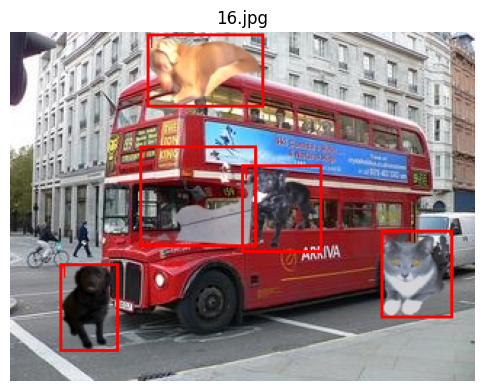

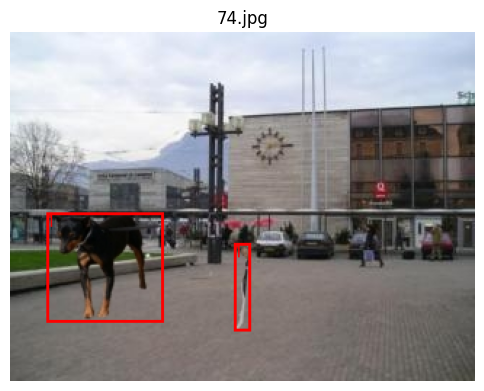

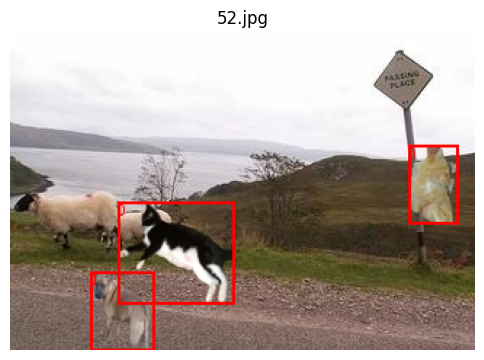

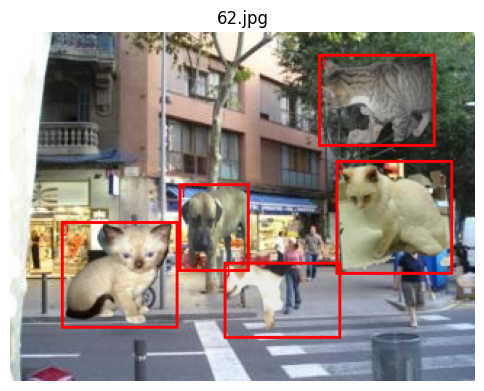

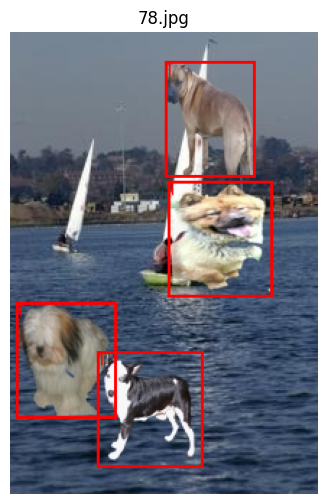

In [ ]:
# === CONFIG ===
images_dir = "/content/ds_final/train/images"
labels_dir = "/content/ds_final/train/labels"
num_samples = 5

# Get all image files
image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]
sampled_files = random.sample(image_files, min(num_samples, len(image_files)))

for image_file in sampled_files:
    image_path = os.path.join(images_dir, image_file)
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(labels_dir, label_file)

    # Load image
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    img_width, img_height = image.size

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            labels = f.readlines()

        for label in labels:
            cls, x_center, y_center, w, h = map(float, label.strip().split())
            x_center *= img_width
            y_center *= img_height
            w *= img_width
            h *= img_height
            x0 = x_center - w / 2
            y0 = y_center - h / 2
            x1 = x_center + w / 2
            y1 = y_center + h / 2
            draw.rectangle([x0, y0, x1, y1], outline="red", width=2)
            draw.text((x0, y0), str(int(cls)), fill="red")

    # Show image with bounding boxes
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(image_file)
    plt.axis("off")
    plt.show()

# SplitTrainValidation

In [ ]:
import os
import shutil
import random

validation = 0.1
test = 0.1

# Assumes test has 100% of data
output_folder = "./ds_final/"
trainfolder = output_folder + "train/"
trainfolderimgs = trainfolder + "images/"
trainfolderlabels = trainfolder + "labels/"
testfolder = output_folder + "test/"
testfolderimgs = testfolder + "images/"
testfolderlabels = testfolder + "labels/"
validfolder = output_folder + "valid/"
validfolderimgs = validfolder + "images/"
validfolderlabels = validfolder + "labels/"

fullSize = len(os.listdir(trainfolderimgs))
validSize = int(fullSize * validation)
testSize = int(fullSize * test)

for i in range(validSize):
    filelist = os.listdir(trainfolderimgs)
    #randomize file list, to not pick files in order
    random.shuffle(filelist)
    filetomove = filelist[i]
    #take out .jpg, .png, etc
    filetomovename = filetomove[:-4]
    #move images
    shutil.move(f"{trainfolderimgs}{filetomove}", f"{validfolderimgs}{filetomove}")
    #move labels
    shutil.move(f"{trainfolderlabels}{filetomovename}.txt", f"{validfolderlabels}{filetomovename}.txt")
for i in range(testSize):
    filetomove = os.listdir(trainfolderimgs)[i]
    #take out .jpg, .png, etc
    filetomovename = filetomove[:-4]
    #move images
    shutil.move(f"{trainfolderimgs}{filetomove}", f"{testfolderimgs}{filetomove}")
    #move labels
    shutil.move(f"{trainfolderlabels}{filetomovename}.txt", f"{testfolderlabels}{filetomovename}.txt")

#Validation
print(f"Train size is now: {len(os.listdir(trainfolderimgs))}")
print(f"Validation size is now: {len(os.listdir(validfolderimgs))}")
print(f"Test size is now: {len(os.listdir(testfolderimgs))}")

# Train a yolo model with the dataset

In [ ]:
# UTIL DON'T RUN
!rm -rf runs

In [ ]:
def clean_labels(split):
    label_dir = f'/content/ds_final/{split}/labels'
    if not os.path.exists(label_dir):
        print(f"Label directory for {split} not found.")
        return

    for label_file in os.listdir(label_dir):
        path = os.path.join(label_dir, label_file)
        with open(path, 'r') as f:
            lines = f.readlines()

        valid_lines = []
        for line in lines:
            try:
                parts = list(map(float, line.strip().split()))
                if len(parts) == 5:
                    _, x, y, w, h = parts
                    if all(0 <= val <= 1 for val in [x, y, w, h]):
                        valid_lines.append(line)
            except Exception as e:
                print(f"Error parsing line in {label_file}: {line} -> {e}")

        if valid_lines:
            with open(path, 'w') as f:
                f.writelines(valid_lines)
        else:
            os.remove(path)
            print(f"❌ Removed invalid label file: {path}")

# Clean labels for all splits
for split in ['train', 'test', 'valid']:
    print(f"🧹 Cleaning {split} labels...")
    clean_labels(split)

print("✅ Done cleaning labels!")


In [ ]:
!pip install ultralytics
from ultralytics import YOLO

# Load a YOLOv8 model (you can also use 'yolov8n.yaml', 'yolov8s.yaml', etc.)
model = YOLO("yolov8l.yaml")  # 'n' = nano, smallest model

# Train the model
model.train(
    data="./ds_final/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16
)

In [ ]:
# Test the model
#model.val(data="ds_final/data.yaml", split="test")

# Load the best trained model
model = YOLO("runs/detect/train/weights/best.pt")

# Run inference on test images
results = model.predict(source="ds_final/test/images", save=True, conf=0.25)

TODO:

* Images are too cropped outside.
* Truncate labels.
* Not overlap too much.
* Better segment objects?
* Limit size of objects.